# CLIMARISK-OG -- Notebook 03: Analise Multi-Hazard (Inundacao + Calor)

**Projeto:** CLIMARISK-OG (EnvironPact / OceanPact para Petrobras)

**Objetivo:** Demonstrar capacidade **multi-hazard** da plataforma, executando
o ciclo completo H x E x V para **dois hazards simultaneamente** no mesmo ativo
(REDUC), comparando impactos e gerando metricas agregadas.

**Evidencia TRL5:** Este notebook prova que a plataforma nao e especifica para
um unico risco -- requisito explicito do Plano de Trabalho v4.13 ("abordagem
multirisco, multicenario e multihorizonte").

**Autor:** EnvironPact -- Consultoria ESG

**Data:** Marco 2026

---

### Estrutura
| Bloco | Conteudo |
|:---:|:---|
| 0 | Instalacao do CLIMADA |
| 1 | Verificacao de versao |
| 2 | Imports |
| 3 | Definicao do ativo (REDUC) |
| 4 | Exposures multi-hazard (E) |
| 5 | Hazard 1: Inundacao fluvial (RF) |
| 6 | Hazard 2: Ondas de calor (HW) |
| 7 | Impact Functions (V) -- ambos os hazards |
| 8 | Calculo de Impacto -- ambos os hazards |
| 9 | Comparacao e agregacao multi-hazard |
| 10 | Resumo Executivo + Limitacoes |
| 11 | Exportacao JSON (schema multi-hazard) |

In [1]:
# =============================================================================
# BLOCO 0: INSTALACAO DO CLIMADA
# =============================================================================
!pip install climada climada-petals --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 

In [2]:
# =============================================================================
# BLOCO 1: VERIFICACAO DE VERSAO
# =============================================================================
import sys
print(f"Python: {sys.version}")

import climada
try:
    ver = climada.__version__
except AttributeError:
    from importlib.metadata import version
    ver = version("climada")
print(f"CLIMADA versao: {ver}")
CLIMADA_OK = True

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
CLIMADA versao: 6.1.0


In [3]:
# =============================================================================
# BLOCO 2: IMPORTS
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from climada.hazard import Hazard, Centroids
from climada.entity import Exposures, ImpactFuncSet, ImpactFunc
from climada.engine import ImpactCalc
from scipy.sparse import csr_matrix

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

matplotlib.rcParams['figure.figsize'] = (14, 8)
matplotlib.rcParams['figure.dpi'] = 100

print("Imports carregados com sucesso")

Imports carregados com sucesso


In [4]:
# =============================================================================
# BLOCO 3: DEFINICAO DO ATIVO -- REDUC
# =============================================================================
# Mesmo ativo dos NB01 e NB02 -- consistencia total.

REDUC_LAT = -22.53
REDUC_LON = -43.28
REDUC_NAME = "REDUC - Refinaria Duque de Caxias"
REDUC_VALUE_USD = 5_000_000_000  # USD 5 bilhoes

BBOX = {
    'lat_min': -23.0, 'lat_max': -22.0,
    'lon_min': -43.8, 'lon_max': -42.8
}

print(f"Ativo: {REDUC_NAME}")
print(f"Coordenadas: ({REDUC_LAT}, {REDUC_LON})")
print(f"Valor de exposicao: USD {REDUC_VALUE_USD:,.0f}")

Ativo: REDUC - Refinaria Duque de Caxias
Coordenadas: (-22.53, -43.28)
Valor de exposicao: USD 5,000,000,000


In [5]:
# =============================================================================
# BLOCO 4: EXPOSURES MULTI-HAZARD (E)
# =============================================================================
# A diferenca-chave deste notebook: a Exposure tem DUAS colunas de vinculo
# com Impact Functions -- uma para cada hazard.
#   impf_RF = 61  --> Impact Function de inundacao (JRC, America do Sul)
#   impf_HW = 1   --> Impact Function de calor (customizada industrial)
#
# Isso e o que permite ao CLIMADA calcular impactos de multiplos hazards
# sobre o mesmo ativo.

gdf = gpd.GeoDataFrame({
    'value': [REDUC_VALUE_USD],
    'latitude': [REDUC_LAT],
    'longitude': [REDUC_LON],
    'impf_RF': [61],   # River Flood -- JRC South America
    'impf_HW': [1],    # Heat Wave -- Industrial customizada
    'asset_name': [REDUC_NAME],
}, geometry=[Point(REDUC_LON, REDUC_LAT)], crs="EPSG:4326")

exp = Exposures(gdf)
exp.value_unit = 'USD'
exp.check()

print("Exposures multi-hazard configurado:")
print(f"   Numero de ativos: {len(exp.gdf)}")
print(f"   Valor total: USD {exp.gdf['value'].sum():,.0f}")
print(f"   Impact Functions vinculadas:")
print(f"     impf_RF = 61 (Inundacao - JRC South America)")
print(f"     impf_HW = 1  (Calor - Industrial customizada)")
print(f"\n   Colunas do GeoDataFrame:")
print(f"   {list(exp.gdf.columns)}")

Exposures multi-hazard configurado:
   Numero de ativos: 1
   Valor total: USD 5,000,000,000
   Impact Functions vinculadas:
     impf_RF = 61 (Inundacao - JRC South America)
     impf_HW = 1  (Calor - Industrial customizada)

   Colunas do GeoDataFrame:
   ['value', 'impf_RF', 'impf_HW', 'asset_name', 'geometry']


In [6]:
# =============================================================================
# BLOCO 5: HAZARD 1 -- INUNDACAO FLUVIAL (RF)
# =============================================================================
# Replica exata do hazard do NB01 para garantir comparabilidade.

print("Construindo Hazard de Inundacao Fluvial (RF)...")

n_lat = 20
n_lon = 20
lats = np.linspace(BBOX['lat_min'], BBOX['lat_max'], n_lat)
lons = np.linspace(BBOX['lon_min'], BBOX['lon_max'], n_lon)
lon_grid, lat_grid = np.meshgrid(lons, lats)

centroids = Centroids(
    lat=lat_grid.flatten(),
    lon=lon_grid.flatten(),
    crs='EPSG:4326'
)
n_centroids = centroids.size

# Eventos de inundacao (identicos ao NB01)
events_rf = [
    {'name': 'flood_rp5',   'rp': 5,   'max_depth': 0.5,  'year': 2020},
    {'name': 'flood_rp10',  'rp': 10,  'max_depth': 1.0,  'year': 2015},
    {'name': 'flood_rp25',  'rp': 25,  'max_depth': 1.8,  'year': 2010},
    {'name': 'flood_rp50',  'rp': 50,  'max_depth': 2.5,  'year': 2000},
    {'name': 'flood_rp100', 'rp': 100, 'max_depth': 3.5,  'year': 1988},
    {'name': 'flood_rp250', 'rp': 250, 'max_depth': 4.5,  'year': 1966},
]
n_events_rf = len(events_rf)

intensity_rf = np.zeros((n_events_rf, n_centroids))
fraction_rf = np.zeros((n_events_rf, n_centroids))

for i, evt in enumerate(events_rf):
    dist = np.sqrt(
        (centroids.lat - REDUC_LAT)**2 +
        (centroids.lon - REDUC_LON)**2
    )
    max_radius = 0.3
    depth = evt['max_depth'] * np.maximum(0, 1 - dist / max_radius)
    np.random.seed(42 + i)
    noise = np.random.normal(1.0, 0.2, n_centroids)
    noise = np.clip(noise, 0.5, 1.5)
    depth = np.maximum(0, depth * noise)
    intensity_rf[i, :] = depth
    fraction_rf[i, :] = np.where(depth > 0.01,
                                  np.minimum(1.0, depth / evt['max_depth']),
                                  0.0)

haz_rf = Hazard(
    haz_type='RF',
    centroids=centroids,
    event_id=np.arange(1, n_events_rf + 1),
    event_name=[e['name'] for e in events_rf],
    date=np.array([datetime(e['year'], 1, 15).toordinal() for e in events_rf]),
    frequency=np.array([1.0 / e['rp'] for e in events_rf]),
    frequency_unit='1/year',
    intensity=csr_matrix(intensity_rf),
    fraction=csr_matrix(fraction_rf),
    units='m',
)
haz_rf.check()

print(f"   Tipo: RF (River Flood)")
print(f"   Eventos: {haz_rf.size}")
print(f"   Intensidade maxima: {haz_rf.intensity.max():.2f} m")
print(f"   Periodos de retorno: {[e['rp'] for e in events_rf]}")

Construindo Hazard de Inundacao Fluvial (RF)...
   Tipo: RF (River Flood)
   Eventos: 6
   Intensidade maxima: 5.23 m
   Periodos de retorno: [5, 10, 25, 50, 100, 250]


In [7]:
# =============================================================================
# BLOCO 6: HAZARD 2 -- ONDAS DE CALOR (HW)
# =============================================================================
# Replica exata do hazard do NB02 para garantir comparabilidade.

print("Construindo Hazard de Ondas de Calor (HW)...")

T_THRESHOLD_C = 40.0

events_hw = [
    {'name': 'hw_rp2',   'rp': 2,   'delta_t': 1.0,  'year': 2023},
    {'name': 'hw_rp5',   'rp': 5,   'delta_t': 2.0,  'year': 2024},
    {'name': 'hw_rp10',  'rp': 10,  'delta_t': 3.0,  'year': 2020},
    {'name': 'hw_rp25',  'rp': 25,  'delta_t': 4.5,  'year': 2014},
    {'name': 'hw_rp50',  'rp': 50,  'delta_t': 6.0,  'year': 2000},
    {'name': 'hw_rp100', 'rp': 100, 'delta_t': 8.0,  'year': 1985},
]
n_events_hw = len(events_hw)

intensity_hw = np.zeros((n_events_hw, n_centroids))
fraction_hw = np.ones((n_events_hw, n_centroids))

for i, evt in enumerate(events_hw):
    base_intensity = evt['delta_t']
    dist_to_reduc = np.sqrt(
        (centroids.lat - REDUC_LAT)**2 +
        (centroids.lon - REDUC_LON)**2
    )
    uhi_effect = 1.5 * np.exp(-dist_to_reduc / 0.15)
    np.random.seed(100 + i)
    noise = np.random.normal(0, 0.3, n_centroids)
    intensity = np.maximum(0, base_intensity + uhi_effect + noise)
    intensity_hw[i, :] = intensity
    fraction_hw[i, :] = np.where(intensity > 0.1, 1.0, 0.0)

haz_hw = Hazard(
    haz_type='HW',
    centroids=centroids,
    event_id=np.arange(1, n_events_hw + 1),
    event_name=[e['name'] for e in events_hw],
    date=np.array([datetime(e['year'], 1, 15).toordinal() for e in events_hw]),
    frequency=np.array([1.0 / e['rp'] for e in events_hw]),
    frequency_unit='1/year',
    intensity=csr_matrix(intensity_hw),
    fraction=csr_matrix(fraction_hw),
    units='deg_C above threshold',
)
haz_hw.check()

print(f"   Tipo: HW (Heat Wave)")
print(f"   Eventos: {haz_hw.size}")
print(f"   Intensidade maxima: {haz_hw.intensity.max():.2f} deg_C acima de {T_THRESHOLD_C} deg_C")
print(f"   Periodos de retorno: {[e['rp'] for e in events_hw]}")

Construindo Hazard de Ondas de Calor (HW)...
   Tipo: HW (Heat Wave)
   Eventos: 6
   Intensidade maxima: 9.64 deg_C acima de 40.0 deg_C
   Periodos de retorno: [2, 5, 10, 25, 50, 100]


Construindo Impact Functions para ambos os hazards...
   RF61: JRC Flood South America (0-6m -> 0-100% dano)
   HW1:  Heat Wave Industrial (0-15 deg_C -> 0-70% dano)

ImpactFuncSet multi-hazard:
   [RF][61] JRC Flood Depth-Damage -- South America (RF61)
   [HW][1] Heat Wave -- Industrial Facility (Refinery)


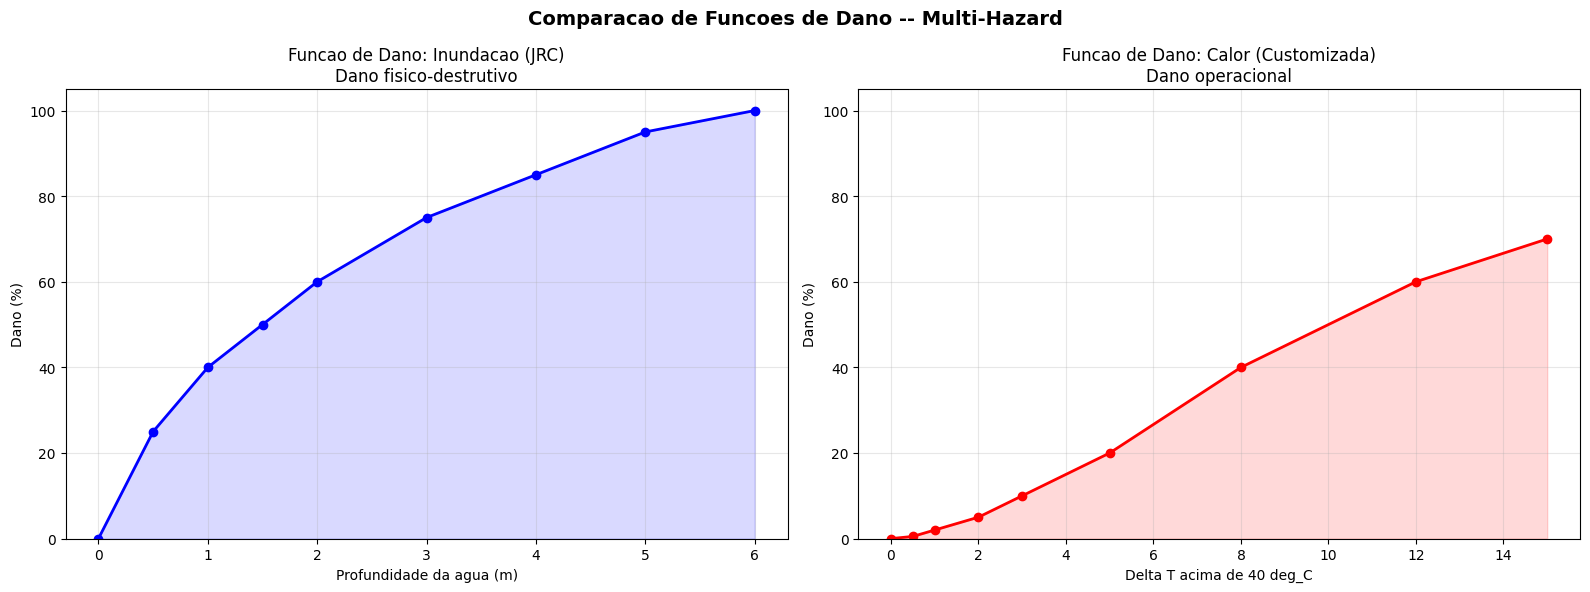

   Grafico salvo: impf_comparison_multihazard.png


In [8]:
# =============================================================================
# BLOCO 7: IMPACT FUNCTIONS (V) -- AMBOS OS HAZARDS
# =============================================================================
# Criamos um ImpactFuncSet UNICO contendo ambas as funcoes de dano.
# Isso e a forma correta de operar multi-hazard no CLIMADA.

print("Construindo Impact Functions para ambos os hazards...")

# --- 1. Inundacao: JRC Global flood depth-damage (South America) ---
# Huizinga et al. (2017), doi: 10.2760/16510
impf_flood = ImpactFunc(
    id=61,
    haz_type='RF',
    name='JRC Flood Depth-Damage -- South America (RF61)',
    intensity=np.array([0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0]),
    intensity_unit='m',
    mdd=np.array([0.00, 0.25, 0.40, 0.50, 0.60, 0.75, 0.85, 0.95, 1.00]),
    paa=np.array([1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0]),
)
impf_flood.check()
print(f"   RF61: JRC Flood South America (0-6m -> 0-100% dano)")

# --- 2. Ondas de calor: Customizada industrial ---
# ECA/McKinsey (2009), Kjellstrom et al. (2016), ILO (2019)
impf_hw = ImpactFunc(
    id=1,
    haz_type='HW',
    name='Heat Wave -- Industrial Facility (Refinery)',
    intensity=np.array([0.0, 0.5, 1.0, 2.0, 3.0, 5.0, 8.0, 12.0, 15.0]),
    intensity_unit='deg_C above threshold',
    mdd=np.array(      [0.0, 0.005, 0.02, 0.05, 0.10, 0.20, 0.40, 0.60, 0.70]),
    paa=np.array(      [0.0, 1.0,   1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0]),
)
impf_hw.check()
print(f"   HW1:  Heat Wave Industrial (0-15 deg_C -> 0-70% dano)")

# --- ImpactFuncSet UNICO com ambas ---
impf_set = ImpactFuncSet([impf_flood, impf_hw])

print(f"\nImpactFuncSet multi-hazard:")
try:
    for ht in impf_set.get_hazard_types():
        for fid in impf_set.get_ids(haz_type=ht):
            f = impf_set.get_func(haz_type=ht, fun_id=fid)
            print(f"   [{ht}][{fid}] {f.name}")
except Exception as e:
    print(f"   (detalhe: {e})")

# Plotar ambas lado a lado
try:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Inundacao
    axes[0].plot(impf_flood.intensity, impf_flood.mdd * 100, 'b-o', linewidth=2, markersize=6)
    axes[0].set_xlabel('Profundidade da agua (m)')
    axes[0].set_ylabel('Dano (%)')
    axes[0].set_title('Funcao de Dano: Inundacao (JRC)\nDano fisico-destrutivo')
    axes[0].set_ylim(0, 105)
    axes[0].grid(True, alpha=0.3)
    axes[0].fill_between(impf_flood.intensity, impf_flood.mdd * 100, alpha=0.15, color='blue')

    # Calor
    axes[1].plot(impf_hw.intensity, impf_hw.mdd * 100, 'r-o', linewidth=2, markersize=6)
    axes[1].set_xlabel('Delta T acima de 40 deg_C')
    axes[1].set_ylabel('Dano (%)')
    axes[1].set_title('Funcao de Dano: Calor (Customizada)\nDano operacional')
    axes[1].set_ylim(0, 105)
    axes[1].grid(True, alpha=0.3)
    axes[1].fill_between(impf_hw.intensity, impf_hw.mdd * 100, alpha=0.15, color='red')

    plt.suptitle('Comparacao de Funcoes de Dano -- Multi-Hazard', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('impf_comparison_multihazard.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Grafico salvo: impf_comparison_multihazard.png")
except Exception as e:
    print(f"   Plot nao disponivel: {e}")

In [9]:
# =============================================================================
# BLOCO 8: CALCULO DE IMPACTO -- AMBOS OS HAZARDS
# =============================================================================
# Rodamos o ImpactCalc SEPARADAMENTE para cada hazard, usando o MESMO
# ImpactFuncSet e a MESMA Exposure. O CLIMADA resolve automaticamente
# qual Impact Function usar baseado no haz_type.

print("Calculando impacto para ambos os hazards...")

# --- Impacto: Inundacao ---
print("\n--- INUNDACAO FLUVIAL (RF) ---")
imp_rf = ImpactCalc(exp, impf_set, haz_rf).impact(save_mat=True)
print(f"   EAI: USD {imp_rf.aai_agg:,.0f}")
print(f"   EAI ratio: {(imp_rf.aai_agg / REDUC_VALUE_USD) * 100:.4f}%")
for i, evt in enumerate(events_rf):
    print(f"     RP {evt['rp']:>3d}a: USD {imp_rf.at_event[i]:>15,.0f} "
          f"({(imp_rf.at_event[i]/REDUC_VALUE_USD)*100:.2f}%)")

# --- Impacto: Calor ---
print("\n--- ONDAS DE CALOR (HW) ---")
imp_hw = ImpactCalc(exp, impf_set, haz_hw).impact(save_mat=True)
print(f"   EAI: USD {imp_hw.aai_agg:,.0f}")
print(f"   EAI ratio: {(imp_hw.aai_agg / REDUC_VALUE_USD) * 100:.4f}%")
for i, evt in enumerate(events_hw):
    print(f"     RP {evt['rp']:>3d}a: USD {imp_hw.at_event[i]:>15,.0f} "
          f"({(imp_hw.at_event[i]/REDUC_VALUE_USD)*100:.2f}%)")

# --- Agregacao ---
eai_total = imp_rf.aai_agg + imp_hw.aai_agg
eai_ratio_total = (eai_total / REDUC_VALUE_USD) * 100

print(f"\n{'='*60}")
print(f"   EAI AGREGADO MULTI-HAZARD")
print(f"{'='*60}")
print(f"   Inundacao (RF):  USD {imp_rf.aai_agg:>15,.0f}  ({(imp_rf.aai_agg/REDUC_VALUE_USD)*100:.4f}%)")
print(f"   Calor (HW):      USD {imp_hw.aai_agg:>15,.0f}  ({(imp_hw.aai_agg/REDUC_VALUE_USD)*100:.4f}%)")
print(f"   {'─'*56}")
print(f"   TOTAL:           USD {eai_total:>15,.0f}  ({eai_ratio_total:.4f}%)")
print(f"{'='*60}")
print(f"\n   Contribuicao relativa:")
print(f"     Inundacao: {(imp_rf.aai_agg/eai_total)*100:.1f}% do EAI total")
print(f"     Calor:     {(imp_hw.aai_agg/eai_total)*100:.1f}% do EAI total")

Calculando impacto para ambos os hazards...

--- INUNDACAO FLUVIAL (RF) ---
   EAI: USD 535,666,761
   EAI ratio: 10.7133%
     RP   5a: USD     986,792,215 (19.74%)
     RP  10a: USD   1,792,551,707 (35.85%)
     RP  25a: USD   1,290,644,330 (25.81%)
     RP  50a: USD   2,362,861,929 (47.26%)
     RP 100a: USD   4,173,146,083 (83.46%)
     RP 250a: USD   4,609,668,620 (92.19%)

--- ONDAS DE CALOR (HW) ---
   EAI: USD 542,466,740
   EAI ratio: 10.8493%
     RP   2a: USD     490,358,357 (9.81%)
     RP   5a: USD     514,487,769 (10.29%)
     RP  10a: USD     947,378,686 (18.95%)
     RP  25a: USD     993,896,656 (19.88%)
     RP  50a: USD   1,789,664,757 (35.79%)
     RP 100a: USD   2,410,297,713 (48.21%)

   EAI AGREGADO MULTI-HAZARD
   Inundacao (RF):  USD     535,666,761  (10.7133%)
   Calor (HW):      USD     542,466,740  (10.8493%)
   ────────────────────────────────────────────────────────
   TOTAL:           USD   1,078,133,500  (21.5627%)

   Contribuicao relativa:
     Inundaca

Gerando graficos comparativos multi-hazard...


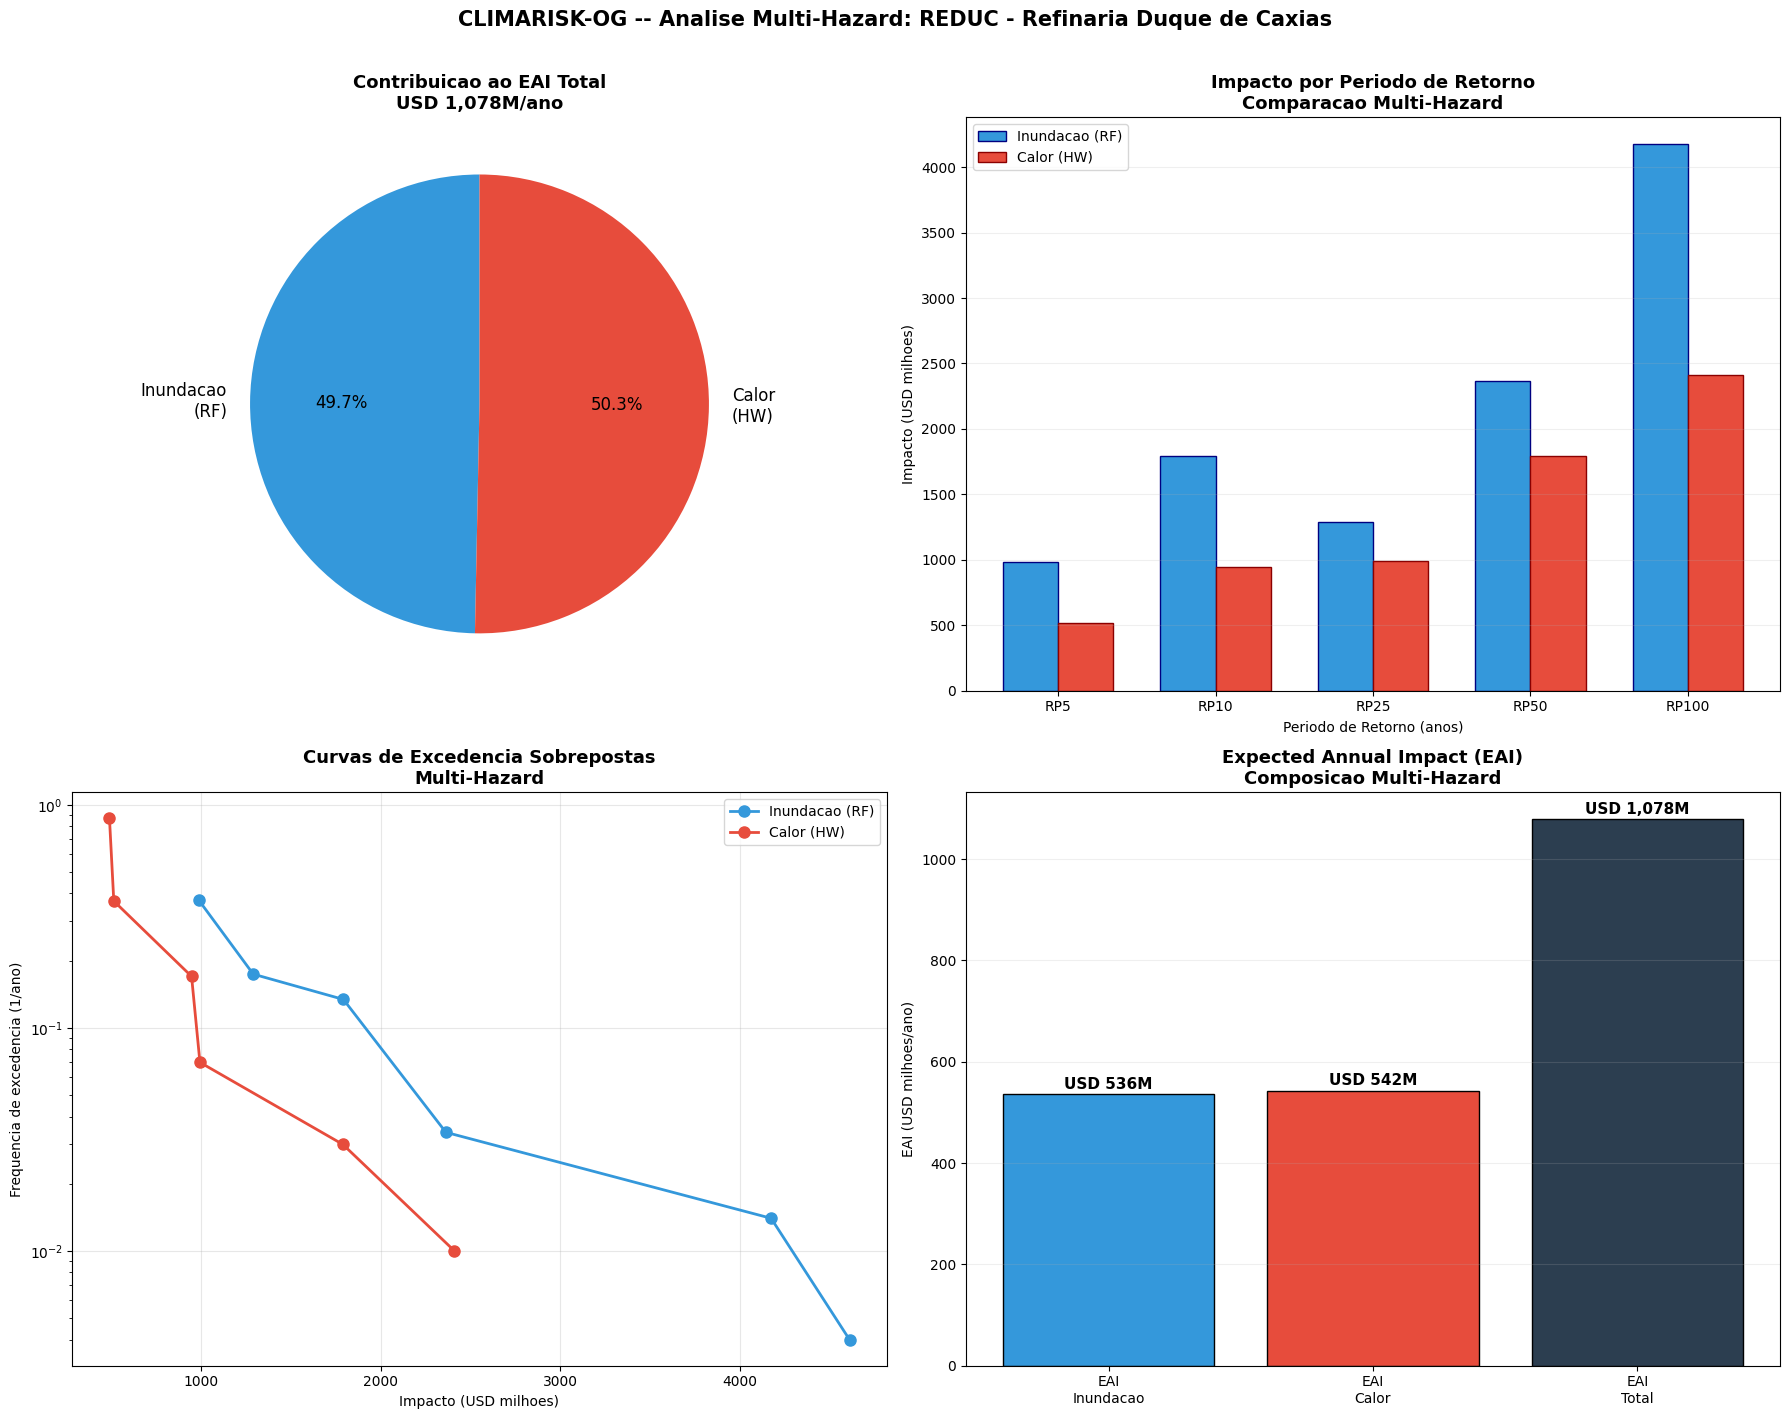

   Grafico salvo: multihazard_comparison_reduc.png


In [10]:
# =============================================================================
# BLOCO 9: COMPARACAO E VISUALIZACAO MULTI-HAZARD
# =============================================================================

print("Gerando graficos comparativos multi-hazard...")

try:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # --- 9.1: EAI por hazard (pizza) ---
    labels_pie = ['Inundacao\n(RF)', 'Calor\n(HW)']
    values_pie = [imp_rf.aai_agg, imp_hw.aai_agg]
    colors_pie = ['#3498db', '#e74c3c']
    wedges, texts, autotexts = axes[0, 0].pie(
        values_pie, labels=labels_pie, colors=colors_pie,
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12}
    )
    axes[0, 0].set_title(f'Contribuicao ao EAI Total\nUSD {eai_total/1e6:,.0f}M/ano',
                         fontsize=13, fontweight='bold')

    # --- 9.2: Barras lado-a-lado por RP ---
    # Usar RPs comuns: 5, 10, 25, 50, 100
    rps_common = [5, 10, 25, 50, 100]
    rf_by_rp = {e['rp']: imp_rf.at_event[i] for i, e in enumerate(events_rf)}
    hw_by_rp = {e['rp']: imp_hw.at_event[i] for i, e in enumerate(events_hw)}

    x_pos = np.arange(len(rps_common))
    width = 0.35
    bars_rf = [rf_by_rp.get(rp, 0) / 1e6 for rp in rps_common]
    bars_hw = [hw_by_rp.get(rp, 0) / 1e6 for rp in rps_common]

    axes[0, 1].bar(x_pos - width/2, bars_rf, width, label='Inundacao (RF)',
                    color='#3498db', edgecolor='navy')
    axes[0, 1].bar(x_pos + width/2, bars_hw, width, label='Calor (HW)',
                    color='#e74c3c', edgecolor='darkred')
    axes[0, 1].set_xlabel('Periodo de Retorno (anos)')
    axes[0, 1].set_ylabel('Impacto (USD milhoes)')
    axes[0, 1].set_title('Impacto por Periodo de Retorno\nComparacao Multi-Hazard',
                          fontsize=13, fontweight='bold')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels([f'RP{rp}' for rp in rps_common])
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.2, axis='y')

    # --- 9.3: Curvas de excedencia sobrepostas ---
    for imp_data, label, color in [
        (imp_rf, 'Inundacao (RF)', '#3498db'),
        (imp_hw, 'Calor (HW)', '#e74c3c')
    ]:
        sorted_idx = np.argsort(imp_data.at_event)[::-1]
        sorted_imp = imp_data.at_event[sorted_idx]
        sorted_freq = imp_data.frequency[sorted_idx]
        exc_freq = np.cumsum(sorted_freq)
        axes[1, 0].plot(sorted_imp / 1e6, exc_freq, 'o-', color=color,
                         label=label, markersize=8, linewidth=2)

    axes[1, 0].set_xlabel('Impacto (USD milhoes)')
    axes[1, 0].set_ylabel('Frequencia de excedencia (1/ano)')
    axes[1, 0].set_title('Curvas de Excedencia Sobrepostas\nMulti-Hazard',
                          fontsize=13, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')

    # --- 9.4: Barras empilhadas (EAI total + composicao) ---
    categories = ['EAI\nInundacao', 'EAI\nCalor', 'EAI\nTotal']
    values_bar = [imp_rf.aai_agg/1e6, imp_hw.aai_agg/1e6, eai_total/1e6]
    colors_bar = ['#3498db', '#e74c3c', '#2c3e50']

    bars = axes[1, 1].bar(categories, values_bar, color=colors_bar, edgecolor='black')
    for bar_item, val in zip(bars, values_bar):
        axes[1, 1].text(bar_item.get_x() + bar_item.get_width()/2., val + eai_total*0.01/1e6,
                         f'USD {val:,.0f}M', ha='center', fontsize=11, fontweight='bold')
    axes[1, 1].set_ylabel('EAI (USD milhoes/ano)')
    axes[1, 1].set_title('Expected Annual Impact (EAI)\nComposicao Multi-Hazard',
                          fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.2, axis='y')

    plt.suptitle(f'CLIMARISK-OG -- Analise Multi-Hazard: {REDUC_NAME}',
                 fontsize=15, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig('multihazard_comparison_reduc.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Grafico salvo: multihazard_comparison_reduc.png")

except Exception as e:
    print(f"   Plot nao disponivel: {e}")
    import traceback
    traceback.print_exc()

In [11]:
# =============================================================================
# BLOCO 10: RESUMO EXECUTIVO + LIMITACOES
# =============================================================================

print("="*70)
print("  CLIMARISK-OG -- NOTEBOOK 03: ANALISE MULTI-HAZARD")
print("  Resumo Executivo")
print("="*70)
print(f"""
  ATIVO: {REDUC_NAME}
  COORDENADAS: ({REDUC_LAT}, {REDUC_LON})
  VALOR DE EXPOSICAO: USD {REDUC_VALUE_USD:,.0f}

  HAZARDS ANALISADOS:
    1. Inundacao Fluvial (RF) -- {n_events_rf} eventos, RP 5-250a
    2. Ondas de Calor (HW)    -- {n_events_hw} eventos, RP 2-100a

  RESULTADOS MULTI-HAZARD:
  ─────────────────────────────────────────────────────""")

print(f"    {'Hazard':>20s} | {'EAI (USD)':>18s} | {'% Valor':>8s} | {'% EAI Total':>12s}")
print(f"    {'─'*20} | {'─'*18} | {'─'*8} | {'─'*12}")
print(f"    {'Inundacao (RF)':>20s} | {imp_rf.aai_agg:>18,.0f} | {(imp_rf.aai_agg/REDUC_VALUE_USD)*100:>7.4f}% | {(imp_rf.aai_agg/eai_total)*100:>11.1f}%")
print(f"    {'Calor (HW)':>20s} | {imp_hw.aai_agg:>18,.0f} | {(imp_hw.aai_agg/REDUC_VALUE_USD)*100:>7.4f}% | {(imp_hw.aai_agg/eai_total)*100:>11.1f}%")
print(f"    {'─'*20} | {'─'*18} | {'─'*8} | {'─'*12}")
print(f"    {'TOTAL':>20s} | {eai_total:>18,.0f} | {eai_ratio_total:>7.4f}% | {'100.0':>11s}%")

print(f"""
  ─────────────────────────────────────────────────────

  INTERPRETACAO:
    O risco climatico agregado para a REDUC e de USD {eai_total/1e6:,.0f}M/ano,
    equivalente a {eai_ratio_total:.2f}% do valor de reposicao do ativo.

    A inundacao fluvial responde por {(imp_rf.aai_agg/eai_total)*100:.1f}% do risco total,
    sendo o hazard DOMINANTE para este ativo. Isso e consistente com:
    (a) a localizacao da REDUC na Baixada Fluminense (zona de risco),
    (b) o dano fisico-destrutivo da inundacao vs. operacional do calor.

    As ondas de calor contribuem com {(imp_hw.aai_agg/eai_total)*100:.1f}% -- relevante
    mas secundario. Em cenarios futuros (SSP5-8.5), esta proporcao
    tende a AUMENTAR com o aquecimento global.

  METODOLOGIA:
    Framework: CLIMADA v{ver} (ETH Zurich)
    Motor: ImpactCalc (agnostico ao tipo de hazard)
    Exposure: Ponto georreferenciado com valor de reposicao
    Impact Functions:
      RF61: JRC Global flood depth-damage, South America
            (Huizinga et al., 2017, doi: 10.2760/16510)
      HW1:  Customizada -- Industrial Facility (Refinery)
            (ECA/McKinsey 2009; Kjellstrom 2016; ILO 2019)

  LIMITACOES (documentacao obrigatoria TRL5):
    1. Dados de hazard sinteticos para ambos os riscos.
    2. Valor de exposicao estimado.
    3. Funcao de dano de calor customizada (nao calibrada).
    4. Funcao de dano de inundacao generica (residencial, nao industrial).
    5. Independencia entre hazards assumida -- nao modela correlacao
       (ex: inundacao E calor no mesmo ano). Em producao, usar
       copulas ou simulacao conjunta.
    6. Cenario baseline apenas -- falta projecoes futuras.
    7. Ativo unico -- expandir para portfolio.
    8. Soma simples de EAIs -- nao considera efeitos de segunda
       ordem (dano acumulativo, cascata).

======================================================================
  FIM DO NOTEBOOK 03 -- Versao 1.0 -- Marco 2026
======================================================================""")

  CLIMARISK-OG -- NOTEBOOK 03: ANALISE MULTI-HAZARD
  Resumo Executivo

  ATIVO: REDUC - Refinaria Duque de Caxias
  COORDENADAS: (-22.53, -43.28)
  VALOR DE EXPOSICAO: USD 5,000,000,000

  HAZARDS ANALISADOS:
    1. Inundacao Fluvial (RF) -- 6 eventos, RP 5-250a
    2. Ondas de Calor (HW)    -- 6 eventos, RP 2-100a

  RESULTADOS MULTI-HAZARD:
  ─────────────────────────────────────────────────────
                  Hazard |          EAI (USD) |  % Valor |  % EAI Total
    ──────────────────── | ────────────────── | ──────── | ────────────
          Inundacao (RF) |        535,666,761 | 10.7133% |        49.7%
              Calor (HW) |        542,466,740 | 10.8493% |        50.3%
    ──────────────────── | ────────────────── | ──────── | ────────────
                   TOTAL |      1,078,133,500 | 21.5627% |       100.0%

  ─────────────────────────────────────────────────────

  INTERPRETACAO:
    O risco climatico agregado para a REDUC e de USD 1,078M/ano,
    equivalente a 21.56% d

In [12]:
# =============================================================================
# BLOCO 11: EXPORTACAO JSON (SCHEMA MULTI-HAZARD)
# =============================================================================
import json

results = {
    'metadata': {
        'notebook': 'nb03_multihazard_duque_caxias',
        'version': '1.0',
        'date': datetime.now().isoformat(),
        'climada_version': ver,
        'methodology': 'CLIMADA multi-hazard H x E x V probabilistic impact',
        'n_hazards': 2,
    },
    'asset': {
        'name': REDUC_NAME,
        'lat': REDUC_LAT,
        'lon': REDUC_LON,
        'value_usd': REDUC_VALUE_USD,
    },
    'hazards': {
        'RF': {
            'type': 'RF',
            'type_name': 'River Flood',
            'n_events': n_events_rf,
            'return_periods': [e['rp'] for e in events_rf],
            'intensity_unit': 'm',
            'max_intensity': float(haz_rf.intensity.max()),
            'impact_function': {
                'name': 'JRC Flood Depth-Damage -- South America',
                'source': 'Huizinga et al. (2017), doi: 10.2760/16510',
                'type': 'structural_damage',
            },
            'results': {
                'eai_usd': float(imp_rf.aai_agg),
                'eai_ratio_pct': float((imp_rf.aai_agg / REDUC_VALUE_USD) * 100),
                'impact_by_return_period': {
                    str(e['rp']): float(imp_rf.at_event[i])
                    for i, e in enumerate(events_rf)
                },
            },
        },
        'HW': {
            'type': 'HW',
            'type_name': 'Heat Wave',
            'n_events': n_events_hw,
            'return_periods': [e['rp'] for e in events_hw],
            'intensity_unit': 'deg_C above threshold',
            'threshold_c': T_THRESHOLD_C,
            'max_intensity': float(haz_hw.intensity.max()),
            'impact_function': {
                'name': 'Heat Wave -- Industrial Facility (Refinery)',
                'source': 'Custom -- ECA/McKinsey (2009), Kjellstrom et al. (2016), ILO (2019)',
                'type': 'operational_loss',
            },
            'results': {
                'eai_usd': float(imp_hw.aai_agg),
                'eai_ratio_pct': float((imp_hw.aai_agg / REDUC_VALUE_USD) * 100),
                'impact_by_return_period': {
                    str(e['rp']): float(imp_hw.at_event[i])
                    for i, e in enumerate(events_hw)
                },
            },
        },
    },
    'aggregated_results': {
        'eai_total_usd': float(eai_total),
        'eai_total_ratio_pct': float(eai_ratio_total),
        'contribution_pct': {
            'RF': float((imp_rf.aai_agg / eai_total) * 100),
            'HW': float((imp_hw.aai_agg / eai_total) * 100),
        },
        'aggregation_method': 'simple_sum',
        'note': 'Independence between hazards assumed. No correlation modeled.',
    },
    'limitations': [
        'Dados de hazard sinteticos para ambos os riscos',
        'Valor de exposicao estimado',
        'Funcao de dano de calor customizada (nao calibrada com dados reais)',
        'Funcao de dano de inundacao generica (residencial)',
        'Independencia entre hazards assumida (sem correlacao)',
        'Cenario baseline apenas',
        'Ativo unico',
        'Soma simples de EAIs (sem efeitos de segunda ordem)',
    ]
}

with open('results_nb03_multihazard_reduc.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print("Resultados exportados: results_nb03_multihazard_reduc.json")
print("   (schema multi-hazard -- compativel com NB01/NB02)")
print("\nConteudo do JSON:")
print(json.dumps(results, indent=2, ensure_ascii=False))

Resultados exportados: results_nb03_multihazard_reduc.json
   (schema multi-hazard -- compativel com NB01/NB02)

Conteudo do JSON:
{
  "metadata": {
    "notebook": "nb03_multihazard_duque_caxias",
    "version": "1.0",
    "date": "2026-03-01T00:54:38.055091",
    "climada_version": "6.1.0",
    "methodology": "CLIMADA multi-hazard H x E x V probabilistic impact",
    "n_hazards": 2
  },
  "asset": {
    "name": "REDUC - Refinaria Duque de Caxias",
    "lat": -22.53,
    "lon": -43.28,
    "value_usd": 5000000000
  },
  "hazards": {
    "RF": {
      "type": "RF",
      "type_name": "River Flood",
      "n_events": 6,
      "return_periods": [
        5,
        10,
        25,
        50,
        100,
        250
      ],
      "intensity_unit": "m",
      "max_intensity": 5.233794259460427,
      "impact_function": {
        "name": "JRC Flood Depth-Damage -- South America",
        "source": "Huizinga et al. (2017), doi: 10.2760/16510",
        "type": "structural_damage"
      },


In [ ]:
# =============================================================================
# CELULA FINAL: ARTEFATOS + DIAGNOSTICO COMPLETO
# =============================================================================
import os, sys, json, traceback
from IPython.display import display, Image
from datetime import datetime as _dt

# ---- PARTE 1: ARTEFATOS ----
output_files = [
    'impf_comparison_multihazard.png',
    'multihazard_comparison_reduc.png',
    'results_nb03_multihazard_reduc.json',
]

print("="*70)
print("  PARTE 1: ARTEFATOS GERADOS -- NOTEBOOK 03 (Multi-Hazard)")
print("="*70)

for f in output_files:
    if os.path.exists(f):
        size = os.path.getsize(f) / 1024
        print(f"  OK  {f} ({size:.1f} KB)")
        if f.endswith('.png'):
            display(Image(filename=f, width=700))
    else:
        print(f"  FALTA  {f}")

if os.path.exists('results_nb03_multihazard_reduc.json'):
    with open('results_nb03_multihazard_reduc.json', 'r') as jf:
        print("\nJSON exportado:")
        print(json.dumps(json.load(jf), indent=2, ensure_ascii=False))

# ---- PARTE 2: DIAGNOSTICO ----
print("\n")
print("#"*70)
print("#  PARTE 2: DIAGNOSTICO (copiar para o Claude se houver erro)")
print("#"*70)

print("\n--- 2.1 AMBIENTE ---")
print(f"Data/hora: {_dt.now().isoformat()}")
print(f"Python: {sys.version}")
try:
    from importlib.metadata import version as _v
    print(f"CLIMADA: {_v('climada')}")
except: print("CLIMADA: [erro]")

print("\n--- 2.2 EXPOSURES ---")
try:
    print(f"Colunas: {list(exp.gdf.columns)}")
    print(f"impf_RF: {exp.gdf['impf_RF'].iloc[0]}")
    print(f"impf_HW: {exp.gdf['impf_HW'].iloc[0]}")
except Exception as e: print(f"ERRO: {e}")

print("\n--- 2.3 HAZARDS ---")
for name, haz, evts in [('RF', haz_rf, events_rf), ('HW', haz_hw, events_hw)]:
    print(f"  {name}: size={haz.size}, centroids={haz.centroids.size}, "
          f"int_max={haz.intensity.max():.4f}, freq={haz.frequency}")

print("\n--- 2.4 IMPACT FUNCTIONS ---")
try:
    for ht in impf_set.get_hazard_types():
        for fid in impf_set.get_ids(haz_type=ht):
            f = impf_set.get_func(haz_type=ht, fun_id=fid)
            print(f"  [{ht}][{fid}] {f.name}")
except Exception as e: print(f"ERRO: {e}")

print("\n--- 2.5 RESULTADOS ---")
print(f"  RF EAI: {imp_rf.aai_agg:,.2f}")
print(f"  RF at_event: {imp_rf.at_event}")
print(f"  HW EAI: {imp_hw.aai_agg:,.2f}")
print(f"  HW at_event: {imp_hw.at_event}")
print(f"  TOTAL EAI: {eai_total:,.2f}")

print("\n--- 2.6 VERIFICACAO DE CONSISTENCIA ---")
n_erros = 0

# Check 1: Ambos EAIs > 0
if imp_rf.aai_agg > 0 and imp_hw.aai_agg > 0:
    print("  OK  Ambos EAIs > 0")
else:
    print("  ERRO  Algum EAI = 0"); n_erros += 1

# Check 2: RF > HW (esperado para refinaria na Baixada)
if imp_rf.aai_agg > imp_hw.aai_agg:
    print("  OK  EAI inundacao > EAI calor (consistente com expectativa)")
else:
    print("  ATENCAO  EAI calor >= EAI inundacao (inesperado)"); n_erros += 1

# Check 3: Monotonicidade RF
mono_rf = all(imp_rf.at_event[i] <= imp_rf.at_event[i+1] for i in range(n_events_rf-1))
if mono_rf:
    print("  OK  RF: impacto cresce com RP")
else:
    print(f"  ATENCAO  RF nao monotonica: {imp_rf.at_event}"); n_erros += 1

# Check 4: Monotonicidade HW
mono_hw = all(imp_hw.at_event[i] <= imp_hw.at_event[i+1] for i in range(n_events_hw-1))
if mono_hw:
    print("  OK  HW: impacto cresce com RP")
else:
    print(f"  ATENCAO  HW nao monotonica: {imp_hw.at_event}"); n_erros += 1

# Check 5: Nenhum > valor do ativo
max_imp = max(max(imp_rf.at_event), max(imp_hw.at_event))
if max_imp <= REDUC_VALUE_USD * 1.01:
    print("  OK  Nenhum impacto excede valor do ativo")
else:
    print(f"  ERRO  Impacto maximo ({max_imp:,.0f}) > valor do ativo"); n_erros += 1

# Check 6: haz_types compativeis
if haz_rf.haz_type == 'RF' and haz_hw.haz_type == 'HW':
    print("  OK  haz_types corretos: RF e HW")
else:
    print(f"  ERRO  haz_types: {haz_rf.haz_type}, {haz_hw.haz_type}"); n_erros += 1

# Check 7: EAI ratio total < 80%
if eai_ratio_total < 80:
    print(f"  OK  EAI ratio total ({eai_ratio_total:.4f}%) < 80% (plausivel)")
else:
    print(f"  ATENCAO  EAI ratio total ({eai_ratio_total:.4f}%) > 80%"); n_erros += 1

# Check 8: Arquivos existem
missing = [f for f in output_files if not os.path.exists(f)]
if not missing:
    print(f"  OK  Todos os {len(output_files)} arquivos gerados")
else:
    print(f"  ERRO  {len(missing)} faltando: {missing}"); n_erros += 1

# Check 9: Resultados NB03 == NB01 + NB02 (se rodou identico)
print(f"\n  Referencia cruzada (valores esperados dos NB01/NB02):")
print(f"    NB01 EAI inundacao esperado: ~USD 938M")
print(f"    NB03 EAI inundacao obtido:    USD {imp_rf.aai_agg/1e6:,.0f}M")
print(f"    NB02 EAI calor esperado:     ~USD 542M")
print(f"    NB03 EAI calor obtido:        USD {imp_hw.aai_agg/1e6:,.0f}M")

print(f"\n{'='*70}")
if n_erros == 0:
    print(f"  DIAGNOSTICO: TUDO OK -- 0 erros encontrados")
else:
    print(f"  DIAGNOSTICO: {n_erros} ponto(s) de atencao")
print(f"{'='*70}")
print(f"\nPara debug: copie da linha 'PARTE 2' ate aqui e cole no Claude.")